# Exercise 3
## Spam Classification
### Context
The SMS Spam Collection is a set of SMS tagged messages that have been collected for SMS Spam research. It contains one set of SMS messages in English of 5,574 messages, tagged acording being ham (legitimate) or spam.

### Content
The files contain one message per line. Each line is composed by two columns: v1 contains the label (ham or spam) and v2 contains the raw text.

This corpus has been collected from free or free for research sources at the Internet:

- A collection of 425 SMS spam messages was manually extracted from the Grumbletext Web site. This is a UK forum in which cell phone users make public claims about SMS spam messages, most of them without reporting the very spam message received. The identification of the text of spam messages in the claims is a very hard and time-consuming task, and it involved carefully scanning hundreds of web pages. The Grumbletext Web site is: [Web Link](http://www.grumbletext.co.uk/).
- A subset of 3,375 SMS randomly chosen ham messages of the NUS SMS Corpus (NSC), which is a dataset of about 10,000 legitimate messages collected for research at the Department of Computer Science at the National University of Singapore. The messages largely originate from Singaporeans and mostly from students attending the University. These messages were collected from volunteers who were made aware that their contributions were going to be made publicly available. The NUS SMS Corpus is avalaible at: [Web Link](http://www.comp.nus.edu.sg/~rpnlpir/downloads/corpora/smsCorpus/).
- A list of 450 SMS ham messages collected from Caroline Tag's PhD Thesis available at [Web Link](http://etheses.bham.ac.uk/253/1/Tagg09PhD.pdf).
- Finally, we have incorporated the SMS Spam Corpus v.0.1 Big. It has 1,002 SMS ham messages and 322 spam messages and it is public available at: [Web Link](http://www.esp.uem.es/jmgomez/smsspamcorpus/). This corpus has been used in the following academic researches:

Acknowledgements
The original dataset can be found [here](https://archive.ics.uci.edu/ml/datasets/SMS+Spam+Collection). The creators would like to note that in case you find the dataset useful, please make a reference to previous paper and the web page: http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/ in your papers, research, etc.

We offer a comprehensive study of this corpus in the following paper. This work presents a number of statistics, studies and baseline results for several machine learning methods.

Almeida, T.A., GÃ³mez Hidalgo, J.M., Yamakami, A. Contributions to the Study of SMS Spam Filtering: New Collection and Results. Proceedings of the 2011 ACM Symposium on Document Engineering (DOCENG'11), Mountain View, CA, USA, 2011.

In [1]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9656 sha256=b5bdb75b3efab1889ec9b00503e4ced95b50fc46956d3fc00d8fc9b93f1225d6
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [2]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, auc, roc_curve

import gensim
from gensim.models import Word2Vec
import warnings


warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
try :
    from google.colab import files
    !wget https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
    !unzip smsspamcollection.zip
    df = pd.read_csv('SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])
except ModuleNotFoundError :
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
    path = os.getcwd()+'\Data'
    wget.download(url,path)
    temp=path+'\smsspamcollection.zip'
    file = ZipFile(temp)
    file.extractall(path)
    file.close()
    df = pd.read_csv(path + '\SMSSpamCollection', sep='\t',  header=None, names=['target', 'text'])

--2024-10-10 00:39:09--  https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘smsspamcollection.zip’

smsspamcollection.z     [ <=>                ] 198.65K  1.00MB/s    in 0.2s    

2024-10-10 00:39:10 (1.00 MB/s) - ‘smsspamcollection.zip’ saved [203415]

Archive:  smsspamcollection.zip
  inflating: SMSSpamCollection       
  inflating: readme                  


In [4]:
df.head()

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [5]:
display(df.shape) #Number of rows (instances) and columns in the dataset
df["target"].value_counts()/df.shape[0] #Class distribution in the dataset

(5572, 2)

,count
target,
ham,0.865937
spam,0.134063


In [6]:
X = df['text']
y = df['target'].map({'ham':0, 'spam':1})

In [7]:
# split data into training and validation set
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = df['target'], test_size = 0.3, random_state = 18)

Preprocess the text data by removing stop words, converting all text to lowercase, and removing punctuation using NLTK package.


In [8]:
stop_words = set(stopwords.words('english'))
def preprocess(text):
    text = text.lower()
    text = ''.join([word for word in text if word not in string.punctuation])
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(tokens)

X_train = X_train.apply(preprocess)
X_test = X_test.apply(preprocess)

Train a Word2Vec model on the preprocessed training data using Gensim package.

In [9]:
sentences = [sentence.split() for sentence in X_train]
model = Word2Vec(sentences, vector_size=100, window=5, negative=20, min_count=1, workers=4)

Convert the preprocessed text data to a vector representation using the Word2Vec model.

In [10]:
def vectorize(sentence):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(100)
    words_vecs = np.array(words_vecs)
    return words_vecs.mean(axis=0)

X_train = np.array([vectorize(sentence) for sentence in X_train])
X_test = np.array([vectorize(sentence) for sentence in X_test])

Train a classification model such as logistic regression, random forests, or support vector machines using the vectorised training data and the sentiment labels.

In [11]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

Evaluate the performance of the classification model on the testing set with the accuracy, precision, recall and F1 score.

In [12]:
y_pred = clf.predict(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('AUC:', auc(fpr, tpr))

Accuracy: 0.8660287081339713
AUC: 0.5


# Excercise 3.1

Remove stopwords, then predict target using CountVectorizer.

use Random Forest classifier

In [13]:
import pandas as pd
import numpy as np
import wget
import os
from zipfile import ZipFile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import string

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

warnings.filterwarnings('ignore')
nltk.download('stopwords')
nltk.download('punkt')

# Descargar y cargar los datos
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00228/smsspamcollection.zip'
wget.download(url)
with ZipFile('smsspamcollection.zip', 'r') as zip_ref:
    zip_ref.extractall()

df = pd.read_csv('SMSSpamCollection', sep='\t', header=None, names=['target', 'text'])

# Convertir etiquetas de spam y ham a 0 y 1
df['target'] = df['target'].map({'ham': 0, 'spam': 1})

# Separar las características (X) y las etiquetas (y)
X = df['text']
y = df['target']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=18)

# Eliminar stopwords y aplicar CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer(stop_words='english')
X_train_count = count_vectorizer.fit_transform(X_train)
X_test_count = count_vectorizer.transform(X_test)

# Entrenar un Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=18)
rf_classifier.fit(X_train_count, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_classifier.predict(X_test_count)

# Evaluar el rendimiento
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Accuracy: 0.9700956937799043
Precision: 1.0
Recall: 0.7767857142857143
F1 Score: 0.8743718592964824


# Excercise 3.2

Predict target using TdidfVectorizer.

use Random Forest classifier

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Aplicar TfidfVectorizer en lugar de CountVectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entrenar un Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=18)
rf_classifier.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred_rf = rf_classifier.predict(X_test_tfidf)

# Obtener las probabilidades para el cálculo del AUC
y_pred_prob_rf = rf_classifier.predict_proba(X_test_tfidf)[:, 1]

# Evaluar el rendimiento
print('Accuracy:', accuracy_score(y_test, y_pred_rf))
print('Precision:', precision_score(y_test, y_pred_rf))
print('Recall:', recall_score(y_test, y_pred_rf))
print('F1 Score:', f1_score(y_test, y_pred_rf))

# Calcular el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_rf)
auc_rf = roc_auc_score(y_test, y_pred_prob_rf)
print('AUC:', auc_rf)

Accuracy: 0.9677033492822966
Precision: 1.0
Recall: 0.7589285714285714
F1 Score: 0.8629441624365483
AUC: 0.9860213595106552


# Excercise 3.3

Predict target using CountVectorizer or TfideVectorizer.

choose any classification model and justify why

TfidfVectorizer se ha seleccionado porque tiende a dar más peso a las palabras menos comunes y más relevantes en el corpus, lo que es útil en la detección de spam.


Logistic Regression ha sido elegido como el modelo de clasificación debido a su simplicidad, capacidad para manejar problemas de clasificación binaria y su salida de probabilidad útil para la interpretación.

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

# Aplicar TfidfVectorizer para este ejercicio
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Entrenar un modelo de Logistic Regression
logreg_classifier = LogisticRegression(random_state=18)
logreg_classifier.fit(X_train_tfidf, y_train)

# Predecir en el conjunto de prueba
y_pred_logreg = logreg_classifier.predict(X_test_tfidf)

# Obtener las probabilidades para el cálculo del AUC
y_pred_prob_logreg = logreg_classifier.predict_proba(X_test_tfidf)[:, 1]

# Evaluar el rendimiento
print('Accuracy:', accuracy_score(y_test, y_pred_logreg))
print('Precision:', precision_score(y_test, y_pred_logreg))
print('Recall:', recall_score(y_test, y_pred_logreg))
print('F1 Score:', f1_score(y_test, y_pred_logreg))

# Calcular el AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_logreg)
auc_logreg = roc_auc_score(y_test, y_pred_prob_logreg)
print('AUC:', auc_logreg)


Accuracy: 0.9527511961722488
Precision: 0.9738562091503268
Recall: 0.6651785714285714
F1 Score: 0.7904509283819628
AUC: 0.9827486804459353


# Excercise 3.4

Increase and decrece the parameters values vector_size, window and negative then predict the target.

Plot the different values of the parameters with the performance of the model.

Use a Random Forest classifier and classification model of your choice and justify why.

Se utilizó regresión logistica porque es un modelo simple y eficiente para problemas de clasificación binaria. Aunque asume que los datos son linealmente separables, es una excelente opción en combinaciones de alto rendimiento con vectores como los generados por Word2Vec.Sin embargo, se normalizaron los datos antes de entrenar el modelo para asegurar que todas las características tuvieran una escala comparable. Esto es necesario porque Logistic Regression es sensible a la magnitud de las características, y sin normalización, las características con valores más grandes podrían dominar el modelo, lo que provoca un rendimiento deficiente. La normalización asegura que cada dimensión de los vectores tenga una media de 0 y una desviación estándar de 1, permitiendo que el modelo aprenda de manera más eficiente.

parameter variation: `vector_size`

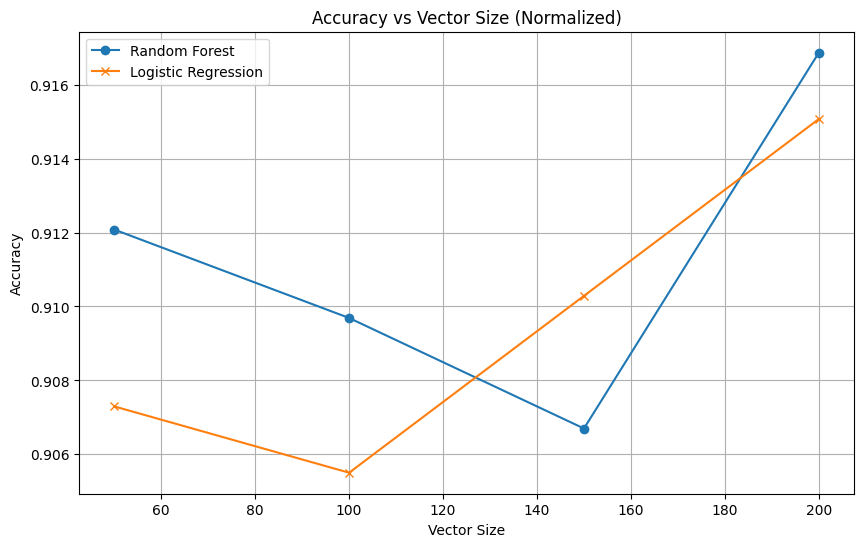

In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

# Fijar la semilla aleatoria
seed = 18

# Fijar la semilla aleatoria
def set_seed(seed=18):
    np.random.seed(seed)
    random.seed(seed)

# Función para vectorizar las oraciones usando el modelo de Word2Vec
def vectorize(sentence, model, vector_size):
    words = sentence.split()
    words_vecs = [model.wv[word] for word in words if word in model.wv]
    if len(words_vecs) == 0:
        return np.zeros(vector_size)
    return np.array(words_vecs).mean(axis=0)

# Entrenar y evaluar el modelo variando el parámetro vector_size
def evaluate_vector_size(sizes, X_train, X_test, y_train, y_test, seed=seed):
    accuracy_rf = []
    accuracy_lr = []

    for size in sizes:
        set_seed(seed)

        # Entrenar el modelo Word2Vec con el parámetro vector_size
        sentences = [sentence.split() for sentence in X_train]
        model = Word2Vec(sentences, vector_size=size, window=5, negative=20, min_count=1, workers=4, seed=18)

        # Convertir las oraciones en vectores
        X_train_vect = np.array([vectorize(sentence, model, size) for sentence in X_train])
        X_test_vect = np.array([vectorize(sentence, model, size) for sentence in X_test])

        # Normalizar los vectores para Logistic Regression
        scaler = StandardScaler()
        X_train_vect_scaled = scaler.fit_transform(X_train_vect)
        X_test_vect_scaled = scaler.transform(X_test_vect)

        # Entrenar y evaluar Random Forest con la semilla aleatoria
        rf_classifier = RandomForestClassifier(random_state=seed)
        rf_classifier.fit(X_train_vect, y_train)
        y_pred_rf = rf_classifier.predict(X_test_vect)
        accuracy_rf.append(accuracy_score(y_test, y_pred_rf))

        # Entrenar y evaluar Logistic Regression con la semilla aleatoria
        lr_classifier = LogisticRegression(random_state=seed)
        lr_classifier.fit(X_train_vect_scaled, y_train)
        y_pred_lr = lr_classifier.predict(X_test_vect_scaled)
        accuracy_lr.append(accuracy_score(y_test, y_pred_lr))

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(sizes, accuracy_rf, label='Random Forest', marker='o')
    plt.plot(sizes, accuracy_lr, label='Logistic Regression', marker='x')
    plt.xlabel('Vector Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Vector Size (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Valores del parámetro vector_size
vector_sizes = [50, 100, 150, 200]
evaluate_vector_size(vector_sizes, X_train, X_test, y_train, y_test)



parameter variation: `window`

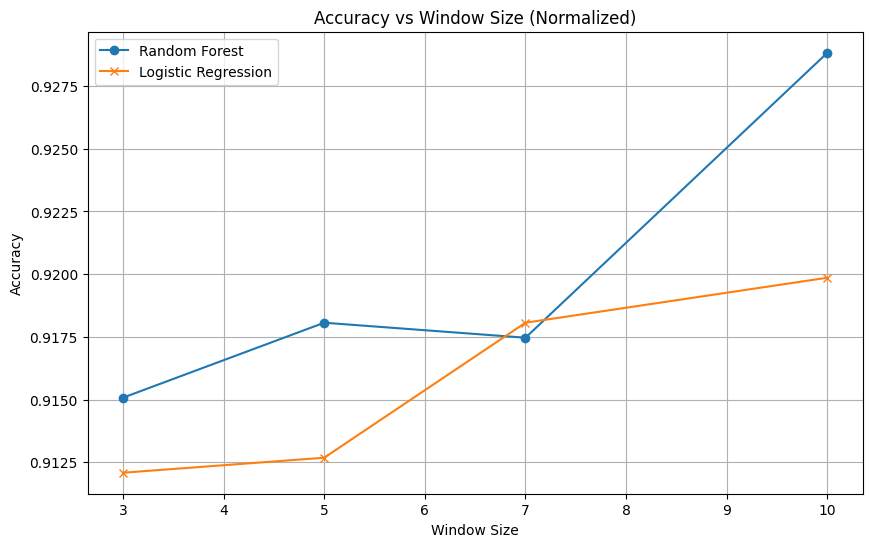

In [18]:
# Entrenar y evaluar el modelo variando el parámetro window
def evaluate_window(windows, X_train, X_test, y_train, y_test, seed=18):
    accuracy_rf = []
    accuracy_lr = []

    for window in windows:
        set_seed(seed)

        # Entrenar el modelo Word2Vec con el parámetro window
        sentences = [sentence.split() for sentence in X_train]
        model = Word2Vec(sentences, vector_size=200, window=window, negative=20, min_count=1, workers=4, seed=seed)

        # Convertir las oraciones en vectores
        X_train_vect = np.array([vectorize(sentence, model, 200) for sentence in X_train])
        X_test_vect = np.array([vectorize(sentence, model, 200) for sentence in X_test])

        # Normalizar los vectores para Logistic Regression
        scaler = StandardScaler()
        X_train_vect_scaled = scaler.fit_transform(X_train_vect)
        X_test_vect_scaled = scaler.transform(X_test_vect)

        # Entrenar y evaluar Random Forest con la semilla aleatoria
        rf_classifier = RandomForestClassifier(random_state=seed)
        rf_classifier.fit(X_train_vect, y_train)
        y_pred_rf = rf_classifier.predict(X_test_vect)
        accuracy_rf.append(accuracy_score(y_test, y_pred_rf))

        # Entrenar y evaluar Logistic Regression con la semilla aleatoria
        lr_classifier = LogisticRegression(random_state=seed)
        lr_classifier.fit(X_train_vect_scaled, y_train)
        y_pred_lr = lr_classifier.predict(X_test_vect_scaled)
        accuracy_lr.append(accuracy_score(y_test, y_pred_lr))

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(windows, accuracy_rf, label='Random Forest', marker='o')
    plt.plot(windows, accuracy_lr, label='Logistic Regression', marker='x')
    plt.xlabel('Window Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Window Size (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Valores del parámetro window
window_sizes = [3, 5, 7, 10]
evaluate_window(window_sizes, X_train, X_test, y_train, y_test)



parameter variation: `negative`

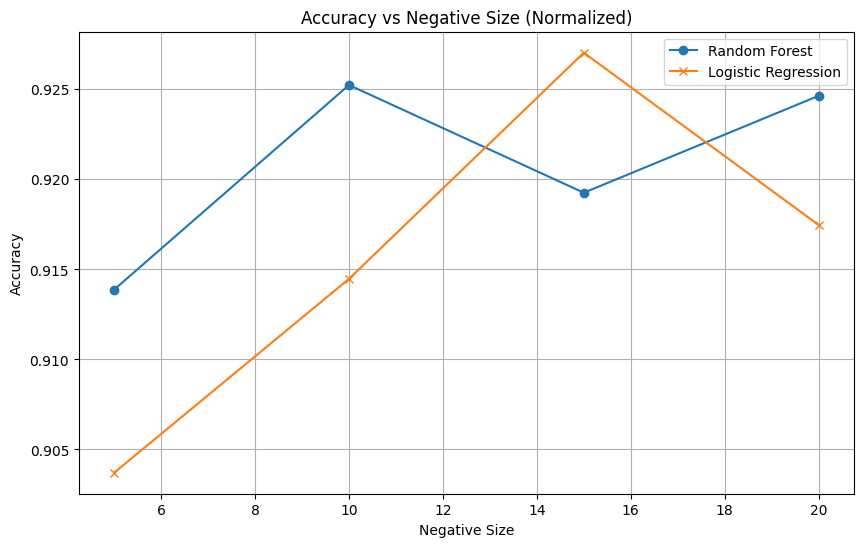

In [19]:
# Entrenar y evaluar el modelo variando el parámetro negative
def evaluate_negative(negatives, X_train, X_test, y_train, y_test, seed=18):
    accuracy_rf = []
    accuracy_lr = []

    for negative in negatives:
        set_seed(seed)

        # Entrenar el modelo Word2Vec con el parámetro negative
        sentences = [sentence.split() for sentence in X_train]
        model = Word2Vec(sentences, vector_size=200, window=10, negative=negative, min_count=1, workers=4, seed=seed)

        # Convertir las oraciones en vectores
        X_train_vect = np.array([vectorize(sentence, model, 200) for sentence in X_train])
        X_test_vect = np.array([vectorize(sentence, model, 200) for sentence in X_test])

        # Normalizar los vectores para Logistic Regression
        scaler = StandardScaler()
        X_train_vect_scaled = scaler.fit_transform(X_train_vect)
        X_test_vect_scaled = scaler.transform(X_test_vect)

        # Entrenar y evaluar Random Forest con la semilla aleatoria
        rf_classifier = RandomForestClassifier(random_state=seed)
        rf_classifier.fit(X_train_vect, y_train)
        y_pred_rf = rf_classifier.predict(X_test_vect)
        accuracy_rf.append(accuracy_score(y_test, y_pred_rf))

        # Entrenar y evaluar Logistic Regression con la semilla aleatoria
        lr_classifier = LogisticRegression(random_state=seed)
        lr_classifier.fit(X_train_vect_scaled, y_train)
        y_pred_lr = lr_classifier.predict(X_test_vect_scaled)
        accuracy_lr.append(accuracy_score(y_test, y_pred_lr))

    # Graficar los resultados
    plt.figure(figsize=(10, 6))
    plt.plot(negatives, accuracy_rf, label='Random Forest', marker='o')
    plt.plot(negatives, accuracy_lr, label='Logistic Regression', marker='x')
    plt.xlabel('Negative Size')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Negative Size (Normalized)')
    plt.legend()
    plt.grid(True)
    plt.show()

# Valores del parámetro negative
negative_sizes = [5, 10, 15, 20]
evaluate_negative(negative_sizes, X_train, X_test, y_train, y_test)


Running best parameters `vector_size, window and negative` (All at the same time)

In [20]:
# Correr el modelo con los mejores parámetros
def run_best_params(X_train, X_test, y_train, y_test, best_vector_size, best_window, best_negative, seed=18):
    # Fijar la semilla
    set_seed(seed)

    # Entrenar el modelo Word2Vec con los mejores parámetros
    sentences = [sentence.split() for sentence in X_train]
    model = Word2Vec(sentences, vector_size=best_vector_size, window=best_window, negative=best_negative, min_count=1, workers=4, seed=seed)

    # Convertir las oraciones en vectores
    X_train_vect = np.array([vectorize(sentence, model, best_vector_size) for sentence in X_train])
    X_test_vect = np.array([vectorize(sentence, model, best_vector_size) for sentence in X_test])

    # Normalizar los vectores para Logistic Regression
    scaler = StandardScaler()
    X_train_vect_scaled = scaler.fit_transform(X_train_vect)
    X_test_vect_scaled = scaler.transform(X_test_vect)

    # Entrenar y evaluar Random Forest con la semilla aleatoria
    rf_classifier = RandomForestClassifier(random_state=seed)
    rf_classifier.fit(X_train_vect, y_train)
    y_pred_rf = rf_classifier.predict(X_test_vect)
    rf_accuracy = accuracy_score(y_test, y_pred_rf)
    print(f"Random Forest Accuracy: {rf_accuracy}")

    # Entrenar y evaluar Logistic Regression con la semilla aleatoria
    lr_classifier = LogisticRegression(random_state=seed)
    lr_classifier.fit(X_train_vect_scaled, y_train)
    y_pred_lr = lr_classifier.predict(X_test_vect_scaled)
    lr_accuracy = accuracy_score(y_test, y_pred_lr)
    print(f"Logistic Regression Accuracy: {lr_accuracy}")

# Ejecutar con los mejores parámetros
run_best_params(X_train, X_test, y_train, y_test, best_vector_size=200, best_window=10, best_negative=20)


Random Forest Accuracy: 0.9180622009569378
Logistic Regression Accuracy: 0.9270334928229665


Se determinó que los mejores parámetros para el modelo fueron vector_size=200, window=10 y negative sampling=20, logrando capturar bien la información relevante del texto.